## Imports

In [ ]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt


## Set random seed for reproducibility

In [2]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Data Loading

In [ ]:
from sklearn.model_selection import train_test_split
param_number = 1
pretrained_dir = f"pretrained/saved_models_{param_number}"
finetuned_dir = "finetuned/saved_models"
os.makedirs(finetuned_dir, exist_ok=True)

data_dir = "../data/balanced_with_augmented_data"

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in dataset.samples]
filenames = [os.path.basename(path) for path, _ in dataset.samples]

label_1_indices = [i for i, label in enumerate(labels) if label == 1]
original_label_1_indices = [i for i in label_1_indices if filenames[i].startswith("original")]

label_1_test_size = int(0.1 * len(label_1_indices))  
label_1_test_indices = original_label_1_indices[:label_1_test_size] 

remaining_label_1_indices = list(set(label_1_indices) - set(label_1_test_indices))

label_0_indices = [i for i, label in enumerate(labels) if label == 0]

train_indices = []
val_indices = []
test_indices = label_1_test_indices + label_0_indices[:int(0.1 * len(label_0_indices))]  

label_1_train_indices, label_1_val_indices = train_test_split(
    remaining_label_1_indices, test_size=0.2, stratify=[labels[i] for i in remaining_label_1_indices], random_state=SEED
)

label_0_train_indices, label_0_val_indices = train_test_split(
    label_0_indices[int(0.1 * len(label_0_indices)):], test_size=0.2, stratify=[labels[i] for i in label_0_indices[int(0.1 * len(label_0_indices)):]], random_state=SEED
)

train_indices.extend(label_1_train_indices + label_0_train_indices)
val_indices.extend(label_1_val_indices + label_0_val_indices)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

from collections import Counter
train_counts = Counter([labels[i] for i in train_indices])
val_counts = Counter([labels[i] for i in val_indices])
test_counts = Counter([labels[i] for i in test_indices])

print(f"Train class distribution: {train_counts}")
print(f"Validation class distribution: {val_counts}")
print(f"Test class distribution: {test_counts}")

Train class distribution: Counter({1: 1980, 0: 1980})
Validation class distribution: Counter({1: 496, 0: 496})
Test class distribution: Counter({1: 275, 0: 275})


## Architecture Definition

In [ ]:
class ConformerTinyOriginal(nn.Module):
    def __init__(self, img_size=128, num_classes=5, embed_dim=64, num_heads=4, num_transformer_layers=1):
        super(ConformerTinyOriginal, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU()
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.transformer(x)
        x = x.mean(dim=0) 
        x = self.fc(x)
        return x

In [ ]:
class ConformerTinyBinary(nn.Module):
    def __init__(self, pretrained_model, num_classes=2):
        super(ConformerTinyBinary, self).__init__()
        
        self.conv = pretrained_model.conv
        self.transformer = pretrained_model.transformer
        
       
        self.fc = nn.Sequential(
            nn.Linear(pretrained_model.fc.in_features, 128),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  
        )

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1) 
        x = self.transformer(x)
        x = x.mean(dim=0)  
        x = self.fc(x)
        return x

## Function Definition

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from scipy import interp

# Saver/Loader function
def save_model(epoch, model, optimizer, path, best=False):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)
    if best:
        best_path = os.path.join(finetuned_dir, f"best_model_epoch{epoch}.pth")
        torch.save(state, best_path)

def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def compute_auc_and_roc(model, dataloader, device, min_tpr=0.8):
    """
    Computes the ROC, AUC, and partial AUC for the given model and dataloader.
    
    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader for evaluation data.
        device: Device to run the computations on (CPU or GPU).
        min_tpr: Minimum TPR threshold for partial AUC computation.
    
    Returns:
        fpr: False positive rates.
        tpr: True positive rates.
        roc_auc: Full area under the ROC curve.
        partial_auc: Partial area under the ROC curve for TPR >= min_tpr.
        y_true: Ground truth labels.
        y_scores: Predicted scores for the positive class.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)


    tpr_threshold_idx = np.where(tpr >= min_tpr)[0]

    if len(tpr_threshold_idx) > 0:
        fpr_partial = fpr[tpr_threshold_idx[0]:]
        tpr_partial = tpr[tpr_threshold_idx[0]:]
        
        partial_auc = auc(fpr_partial, tpr_partial)
        normalized_pauc = (partial_auc / (1 - fpr_partial[0])) * 0.2
    else:
        normalized_pauc = 0.0

    return fpr, tpr, roc_auc, normalized_pauc, y_true, y_scores


## Load Pretrained Weights

In [ ]:
def find_latest_pretrained_model(directory):
    model_files = glob.glob(os.path.join(directory, "best_model_epoch*.pth"))
    if not model_files:
        raise FileNotFoundError(f"No model files found in {directory}")
    latest_model = max(model_files, key=lambda x: int(x.split("best_model_epoch")[1].split(".pth")[0]))
    return latest_model

pretrained_model_path = find_latest_pretrained_model(pretrained_dir)
print(f"Loading pretrained model: {pretrained_model_path}")

original_model = ConformerTinyOriginal(
    img_size=128, 
    num_classes=5, 
    embed_dim=128, 
    num_heads=4, 
    num_transformer_layers=3
)
checkpoint = torch.load(pretrained_model_path)
original_model.load_state_dict(checkpoint['model_state_dict'])


Loading pretrained model: pretrained/saved_models_1\best_model_epoch19.pth


c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\jonec\AppData\Local\Temp\ipykernel_28020\552145580.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

<All keys matched successfully>

## Model Init

In [ ]:
fine_tuned_model = ConformerTinyBinary(pretrained_model=original_model, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
fine_tuned_model = fine_tuned_model.to(device)

Device: cuda


In [ ]:
# Params
learning_rate = 1e-4  
num_epochs = 20  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=learning_rate)


## Training

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')

val_aucs = []
val_paucs = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(fine_tuned_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    train_loss, train_acc = validate(fine_tuned_model, train_loader, criterion, device)
    train_accuracies.append(train_acc)

    val_loss, val_acc = validate(fine_tuned_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    fpr, tpr, roc_auc, partial_auc, _, _ = compute_auc_and_roc(fine_tuned_model, val_loader, device)
    val_aucs.append(roc_auc)
    val_paucs.append(partial_auc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {roc_auc:.4f}, Val pAUC: {partial_auc:.4f}")

    save_model(epoch, fine_tuned_model, optimizer, os.path.join(finetuned_dir, f"epoch{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(epoch+1, fine_tuned_model, optimizer, os.path.join(finetuned_dir, f"best_model_epoch{epoch+1}.pth"), best=True)

c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/20 - Train Loss: 0.5042, Train Acc: 0.7798, Val Loss: 0.5059, Val Acc: 0.7702, Val AUC: 0.8541, Val pAUC: 0.1873
Epoch 2/20 - Train Loss: 0.4101, Train Acc: 0.8205, Val Loss: 0.4348, Val Acc: 0.8135, Val AUC: 0.8829, Val pAUC: 0.1877
Epoch 3/20 - Train Loss: 0.3942, Train Acc: 0.8333, Val Loss: 0.4173, Val Acc: 0.8417, Val AUC: 0.8964, Val pAUC: 0.1876
Epoch 4/20 - Train Loss: 0.3652, Train Acc: 0.8508, Val Loss: 0.3943, Val Acc: 0.8397, Val AUC: 0.9045, Val pAUC: 0.1894
Epoch 5/20 - Train Loss: 0.3497, Train Acc: 0.8538, Val Loss: 0.3787, Val Acc: 0.8468, Val AUC: 0.9131, Val pAUC: 0.1902
Epoch 6/20 - Train Loss: 0.3422, Train Acc: 0.8626, Val Loss: 0.3796, Val Acc: 0.8427, Val AUC: 0.9171, Val pAUC: 0.1907
Epoch 7/20 - Train Loss: 0.3254, Train Acc: 0.8697, Val Loss: 0.3638, Val Acc: 0.8508, Val AUC: 0.9231, Val pAUC: 0.1915
Epoch 8/20 - Train Loss: 0.3138, Train Acc: 0.8768, Val Loss: 0.3559, Val Acc: 0.8488, Val AUC: 0.9258, Val pAUC: 0.1916
Epoch 9/20 - Train Loss: 0.3058,

## Testing

Highest epoch found: 17
Loading best model from: finetuned/saved_models\best_model_epoch17.pth


C:\Users\jonec\AppData\Local\Temp\ipykernel_28020\3491780999.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       275
           1       0.88      0.80      0.84       275

    accuracy                           0.84       550
   macro avg       0.85      0.84      0.84       550
weighted avg       0.85      0.84      0.84       550

Classification report saved at: finetuned/saved_models\classification_report.txt


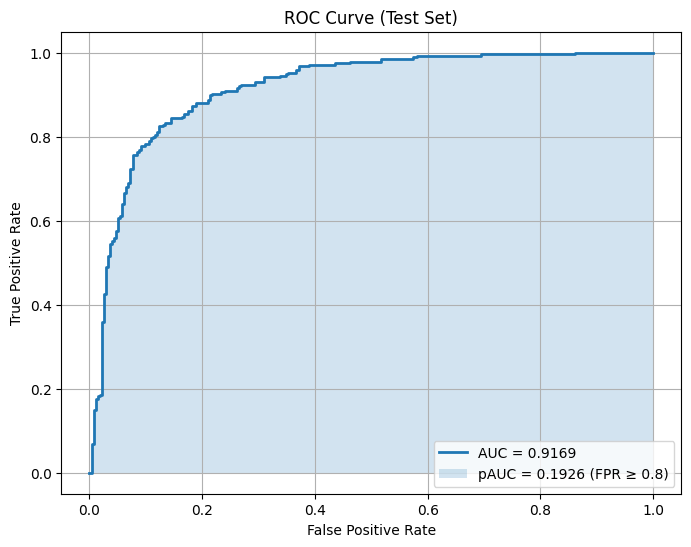

Test ROC Curve plot saved at: finetuned/saved_models\test_roc_curve.png


In [ ]:
import glob
import re
import os

model_files = glob.glob(os.path.join(finetuned_dir, "best_model_epoch*.pth"))
if not model_files:
    raise FileNotFoundError(f"No model files found in {finetuned_dir} matching pattern 'best_model_epoch*.pth'")

epoch_numbers = [
    int(re.search(r"best_model_epoch(\d+)\.pth", os.path.basename(file)).group(1))
    for file in model_files
]

highest_epoch = max(epoch_numbers)
print(f"Highest epoch found: {highest_epoch}")

best_model_path = os.path.join(finetuned_dir, f"best_model_epoch{highest_epoch}.pth")
print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

fpr, tpr, roc_auc, partial_auc, y_true, y_scores = compute_auc_and_roc(fine_tuned_model, test_loader, device)

y_pred = [1 if score >= 0.5 else 0 for score in y_scores]
class_report = classification_report(y_true, y_pred, target_names=dataset.classes)
print("Classification Report:")
print(class_report)

report_path = os.path.join(finetuned_dir, "classification_report.txt")
with open(report_path, "w") as report_file:
    report_file.write(class_report)

print(f"Classification report saved at: {report_path}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.fill_between(fpr, tpr, alpha=0.2, label=f"pAUC = {partial_auc:.4f} (FPR ≥ 0.8)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)

roc_plot_path = os.path.join(finetuned_dir, "test_roc_curve.png")
plt.savefig(roc_plot_path, bbox_inches="tight")
plt.show()

print(f"Test ROC Curve plot saved at: {roc_plot_path}")

## Plotting

Test Accuracy: 0.8436


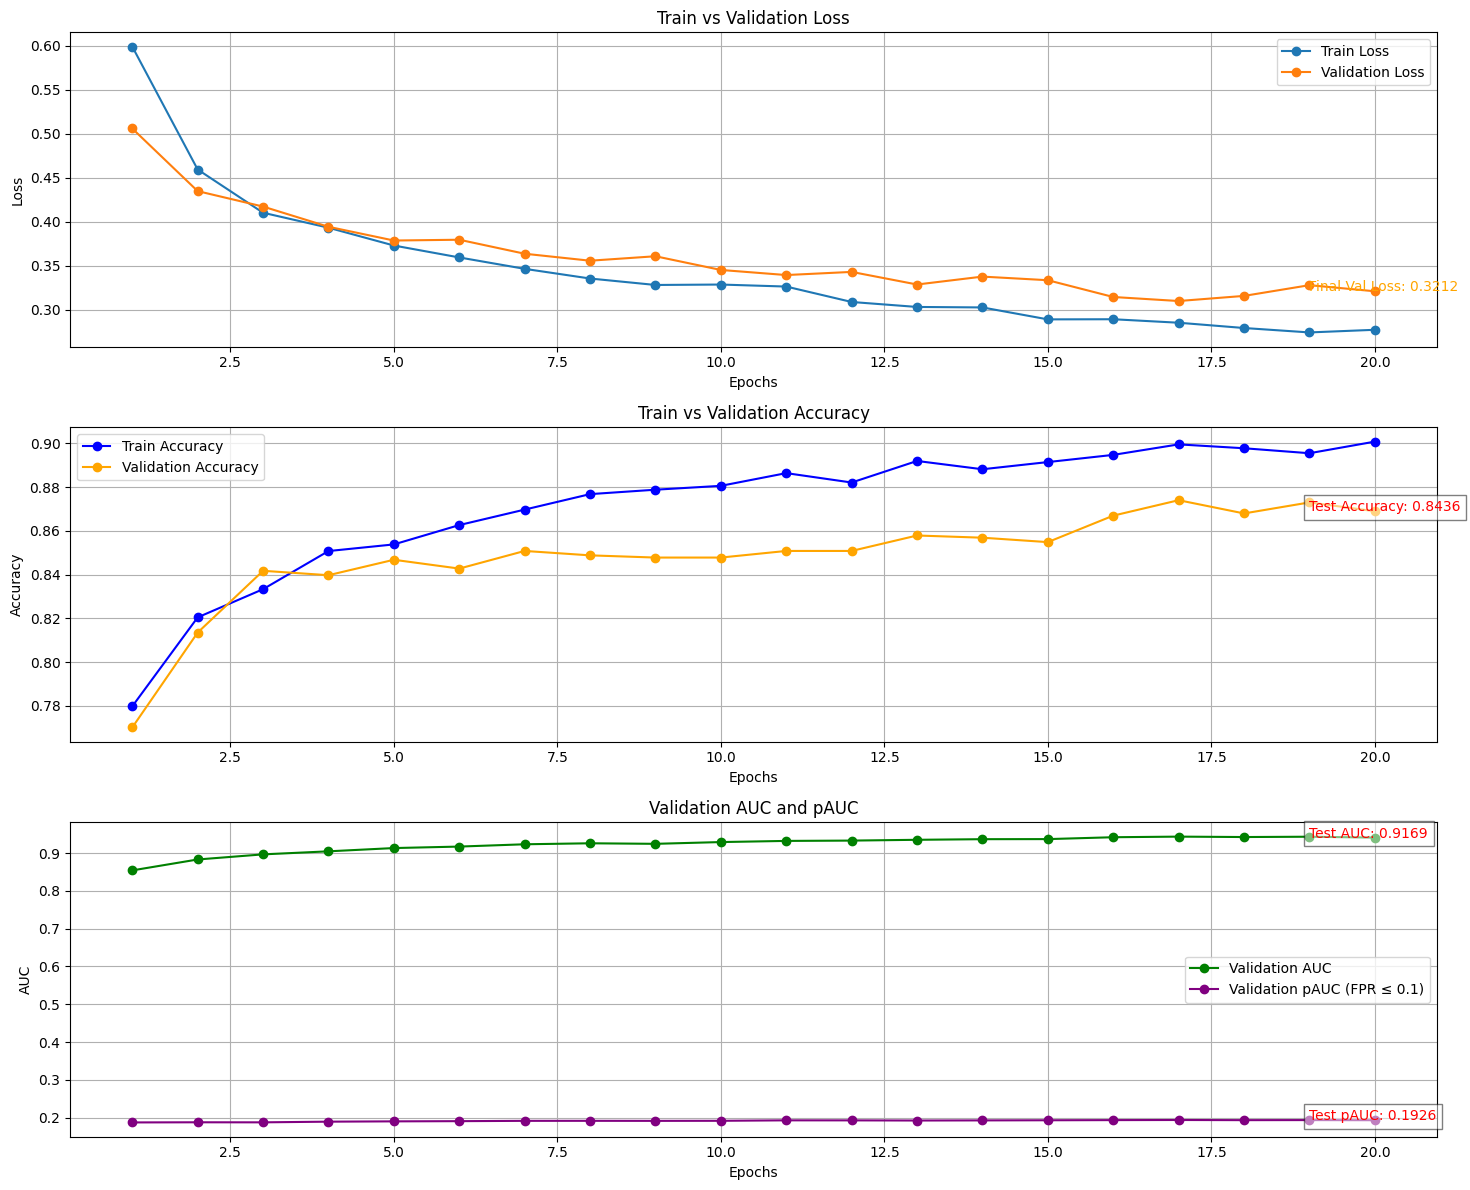

Combined metrics plot saved at: finetuned/saved_models\combined_metrics.png


In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)


plt.text(num_epochs - 1, val_losses[-1], f"Final Val Loss: {val_losses[-1]:.4f}", 
         fontsize=10, color='orange')

plt.subplot(3, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

test_accuracy = sum([y_true[i] == y_pred[i] for i in range(len(y_true))]) / len(y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")
plt.text(num_epochs - 1, val_accuracies[-1], f"Test Accuracy: {test_accuracy:.4f}", 
         fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.5))

plt.subplot(3, 1, 3)
plt.plot(range(1, num_epochs + 1), val_aucs, label="Validation AUC", marker='o', color='green')
plt.plot(range(1, num_epochs + 1), val_paucs, label="Validation pAUC (FPR ≤ 0.1)", marker='o', color='purple')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Validation AUC and pAUC")
plt.legend()
plt.grid(True)

plt.text(num_epochs - 1, val_aucs[-1], f"Test AUC: {roc_auc:.4f}", 
         fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.5))
plt.text(num_epochs - 1, val_paucs[-1], f"Test pAUC: {partial_auc:.4f}", 
         fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.5))

combined_plot_path = os.path.join(finetuned_dir, "combined_metrics.png")
plt.tight_layout()
plt.savefig(combined_plot_path, bbox_inches="tight")
plt.show()

print(f"Combined metrics plot saved at: {combined_plot_path}")
